In [30]:
import os

In [31]:
# I'm re-positioning the train data so that keras can read it.
PATH = "sign_data/train/"

for i in os.listdir(PATH):
    
    contol = i.split("_")
    
    try:
    
        if contol[1]=="forg":
            
            os.system("cp -r {} Train/Fake".format(PATH+i))
            
    except:
        
        os.system("cp -r {} Train/Real".format(PATH+i))

In [32]:
PATH = "sign_data/test/"

for i in os.listdir(PATH):
    
    contol = i.split("_")
    
    try:
    
        if contol[1]=="forg":
            
            os.system("cp -r {} Test/Fake".format(PATH+i))
            
    except:
        
        os.system("cp -r {} Test/Real".format(PATH+i))

In [33]:
# Dataset locations
train_dir = os.path.join("Train/") 
test_dir = os.path.join("Test/") 

In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

In [35]:
SIZE = 224

In [36]:
# loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'sign_data/train/',
    image_size=(224, 224)
)

Found 1649 files belonging to 128 classes.


In [37]:
# loading training data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'sign_data/test/',
    seed=42,
    image_size=(224, 224)
)

Found 500 files belonging to 42 classes.


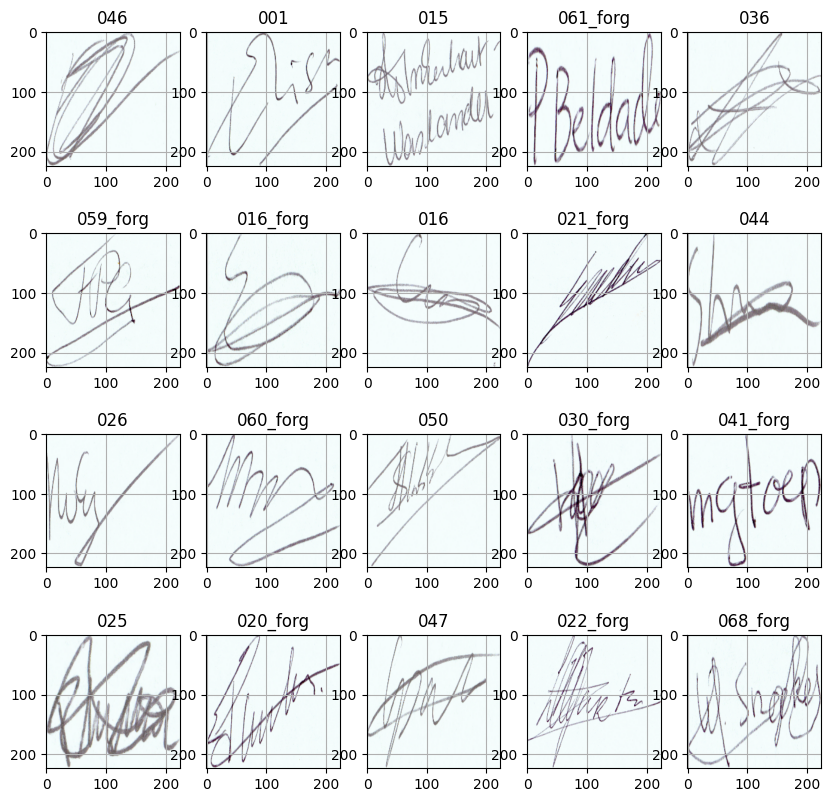

In [38]:
class_names = training_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # print(images[i])
        plt.title(class_names[labels[i]])
        plt.grid(True)

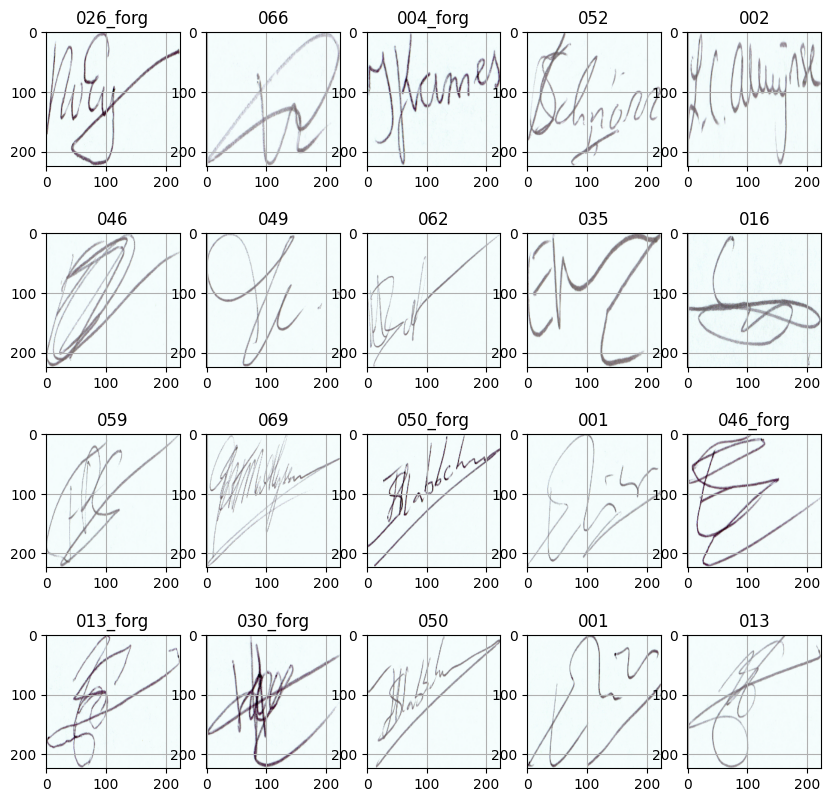

In [39]:
class_names = training_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # print(images[i])
        plt.title(class_names[labels[i]])
        plt.grid(True)

In [40]:
def rotate_and_center(image, angle):
    
    height, width = image.shape[:2]
    
    
    center = (width // 2, height // 2)
    
    
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    
    
    max_dim = max(width, height)
    new_width = max_dim
    new_height = max_dim
    
    
    top = (new_height - height) // 2
    left = (new_width - width) // 2
    
    
    centered_image = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    centered_image[top:top+height, left:left+width] = rotated_image
    
    return centered_image

In [41]:
import cv2
import os
import glob

train_data = []
train_labels = []

for per in os.listdir('sign_data/train/'):
    for data in glob.glob('sign_data/train/' +per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.medianBlur(img, 5)
        img = rotate_and_center(img, 15)
        img = cv2.resize(img, (SIZE,SIZE))
        train_data.append([img])
        if per[-1]=='g':
            train_labels.append(np.array(1))
        else:
            train_labels.append(np.array(0))
train_data = np.array(train_data)/255.0
train_labels = np.array(train_labels)

#Test Data
test_data = []
test_labels = []
for per in os.listdir('sign_data/test/'):
    for data in glob.glob('sign_data/test/' +per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.medianBlur(img, 5)
        img = rotate_and_center(img, 15)
        img = cv2.resize(img, (SIZE,SIZE))
        test_data.append([img])
        if per[-1]=='g':
            test_labels.append(np.array(1))
        else:
            test_labels.append(np.array(0))
test_data = np.array(test_data)/255.0
test_labels = np.array(test_labels)
print(train_labels)

[0 0 0 ... 1 1 1]


In [42]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels)

In [43]:
train_data = train_data.reshape(-1, SIZE,SIZE, 3)
test_data = test_data.reshape(-1, SIZE,SIZE, 3)

In [16]:
train_data.shape
train_labels.shape

(1649, 2)

In [17]:
from sklearn.utils import shuffle
train_data,train_labels = shuffle(train_data,train_labels)
test_data,test_labels = shuffle(test_data,test_labels)

In [18]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

base_model =tf.keras.applications.vgg19.VGG19(
    include_top= False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
)
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
i=0
while i != 5:
    base_model.layers[i].trainable = False
    i+=1
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(2, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.legacy.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]

progess = model.fit(train_data,train_labels, batch_size=32, callbacks=early_stop, epochs=100,validation_split=.25)

Epoch 1/100
39/39 [==============================] - 358s 9s/step - loss: 0.7541 - accuracy: 0.5194 - val_loss: 0.7200 - val_accuracy: 0.5375
Epoch 2/100
39/39 [==============================] - 349s 9s/step - loss: 0.6716 - accuracy: 0.5898 - val_loss: 0.5690 - val_accuracy: 0.7482
Epoch 3/100
39/39 [==============================] - 348s 9s/step - loss: 0.5082 - accuracy: 0.7581 - val_loss: 0.2958 - val_accuracy: 0.8910
Epoch 4/100
39/39 [==============================] - 346s 9s/step - loss: 0.2705 - accuracy: 0.8908 - val_loss: 0.2303 - val_accuracy: 0.9128
Epoch 5/100
39/39 [==============================] - 347s 9s/step - loss: 0.1422 - accuracy: 0.9466 - val_loss: 0.1253 - val_accuracy: 0.9564
Epoch 6/100
39/39 [==============================] - 370s 10s/step - loss: 0.1805 - accuracy: 0.9312 - val_loss: 0.1574 - val_accuracy: 0.9322
Epoch 7/100
39/39 [==============================] - 365s 9s/step - loss: 0.1466 - accuracy: 0.9434 - val_loss: 0.1460 - val_accuracy: 0.9467
Epoch

<Figure size 640x480 with 0 Axes>

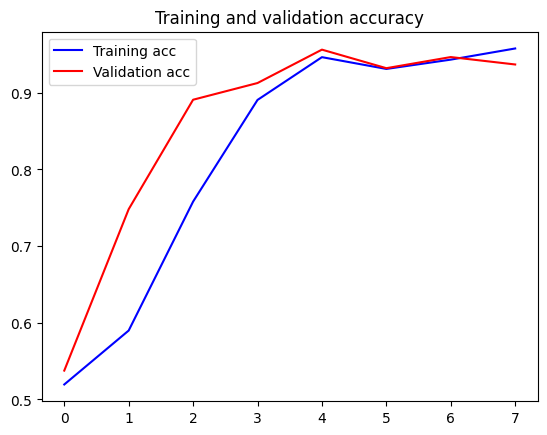

<Figure size 640x480 with 0 Axes>

In [21]:
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

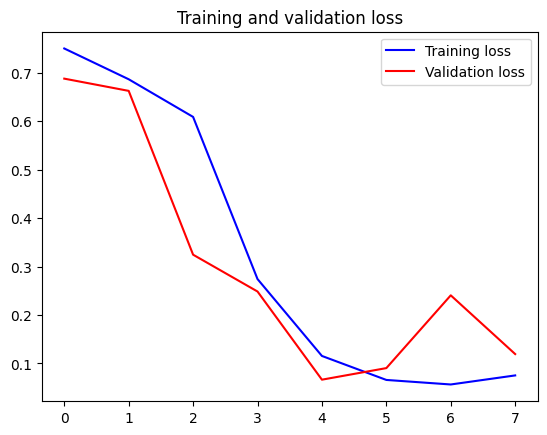

In [21]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [22]:
pred = model.predict(test_data)

16/16 [==============================] - 37s 2s/step


In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score

yt = np.argmax(pred,axis=1)

print(f"Accuracy Score: {accuracy_score(yt, test_labels)}")
print(f"Confusion Matrix: \n {confusion_matrix( yt, test_labels)}")
#confusion_matrix( test_labels, yt)
print(f"Precision: {precision_score(test_labels, yt)}")


print(f"Recall: {recall_score(test_labels,yt)}")

Accuracy Score: 0.992
Confusion Matrix: 
 [[249   1]
 [  3 247]]
Precision: 0.988
Recall: 0.9959677419354839


In [26]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(test_labels , yt)

tn, fp, fn, tp = confusion_mat.ravel()

frr = fn / (fn + tp)

far = fp / (fp + tn)

print("FRR:", frr)
print("FAR:", far)

FRR: 0.004032258064516129
FAR: 0.011904761904761904


In [25]:
model.save('modeloVGG19D.h5')

In [22]:
model = load_model('modeloVGG19D.h5')

In [44]:
def cambio(imagen):
    ruta = imagen
    archivo = []
    SIZE = 224 
    img = cv2.imread(ruta)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE,SIZE))
    img = rotate_and_center(img, 15)
    archivo.append([img])
    archivo = np.array(archivo)/255.0
    a=archivo.reshape(-1, SIZE,SIZE, 3)
    return a

In [45]:
ejemplo = 'sign_data/train/001_forg/0119001_01.png'
a = cambio(ejemplo)

In [46]:
resultado = model.predict(a)

1/1 [==============================] - 0s 266ms/step


In [47]:
resultado_final= np.argmax(resultado,axis=1)

In [48]:
print(resultado_final)

[1]
